In [1]:
import numpy as np
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle

In [2]:
# Load the data
df = pd.read_csv("telco_customer_churn.csv")
dff = df.copy()
dff = dff.drop(columns=["customerID"])

In [3]:
# Identify categorical columns
categorical_columns = dff.select_dtypes(include="object").columns

# Replace "No internet service" and "No phone service" with "No"
dff.replace(["No internet service", "No phone service"], "No", inplace=True)

# Convert TotalCharges to numeric and fill missing values with median
dff['TotalCharges'] = pd.to_numeric(dff['TotalCharges'], errors='coerce')
dff['TotalCharges'].fillna(dff['TotalCharges'].median(), inplace=True)

In [4]:
for i in categorical_columns:
    print(f"{i}:{dff[i].unique()}")

gender:['Female' 'Male']
Partner:['Yes' 'No']
Dependents:['No' 'Yes']
PhoneService:['No' 'Yes']
MultipleLines:['No' 'Yes']
InternetService:['DSL' 'Fiber optic' 'No']
OnlineSecurity:['No' 'Yes']
OnlineBackup:['Yes' 'No']
DeviceProtection:['No' 'Yes']
TechSupport:['No' 'Yes']
StreamingTV:['No' 'Yes']
StreamingMovies:['No' 'Yes']
Contract:['Month-to-month' 'One year' 'Two year']
PaperlessBilling:['Yes' 'No']
PaymentMethod:['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges:[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn:['No' 'Yes']


In [5]:
# Encode Yes/No values as 1/0
yes_no_mapping = {"No": 0, "Yes": 1}
for col in categorical_columns:
    if dff[col].dtype == object:
        unique_values = dff[col].dropna().unique()
        if set(unique_values) <= set(yes_no_mapping.keys()):
            dff[col] = dff[col].map(yes_no_mapping)

In [6]:
missing_values = dff.isna().sum()
print(missing_values)

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [8]:
dff.dtypes

gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService      object
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [9]:
# Separate features and target
X = dff.drop(columns=["Churn"])
y = dff["Churn"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

In [10]:
# Preprocessing for categorical and numerical features
categorical_features = X_train.select_dtypes("object").columns
categorical_preprocessing = Pipeline(steps=[
    ("Encoding", OneHotEncoder(drop="first", handle_unknown="ignore"))
])
numerical_features = X_train.select_dtypes("number").columns
numerical_preprocessing = Pipeline(steps=[
    ("Scaling", MinMaxScaler())
])
transformer = ColumnTransformer(
    transformers=[
        ('Categorical', categorical_preprocessing, categorical_features),
        ('Numerical', numerical_preprocessing, numerical_features)
    ], remainder='passthrough'
)
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('Categorical',
                                 Pipeline(steps=[('Encoding',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 Index(['gender', 'InternetService', 'Contract', 'PaymentMethod'], dtype='object')),
                                ('Numerical',
                                 Pipeline(steps=[('Scaling', MinMaxScaler())]),
                                 Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object'))])

In [11]:
# Fit and save the transformer
transformer.fit(X_train)
with open('transformer.pkl', 'wb') as f:
    pickle.dump(transformer, f)

Build Model H5

In [12]:
# Transform the data
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)

In [13]:
# Define input dimension
input_dim = X_train_transformed.shape[1]
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(18, activation="relu", input_dim=input_dim),
    tf.keras.layers.Dense(18, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
#compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
# Train the model
history = model.fit(X_train_transformed, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
141/141 [==============================] - 1s 3ms/step - loss: 0.5639 - accuracy: 0.7324 - val_loss: 0.4715 - val_accuracy: 0.7480
Epoch 2/100
141/141 [==============================] - 0s 2ms/step - loss: 0.4532 - accuracy: 0.7324 - val_loss: 0.4459 - val_accuracy: 0.7480
Epoch 3/100
141/141 [==============================] - 0s 2ms/step - loss: 0.4408 - accuracy: 0.7639 - val_loss: 0.4447 - val_accuracy: 0.7941
Epoch 4/100
141/141 [==============================] - 0s 1ms/step - loss: 0.4366 - accuracy: 0.7928 - val_loss: 0.4378 - val_accuracy: 0.7888
Epoch 5/100
141/141 [==============================] - 0s 1ms/step - loss: 0.4341 - accuracy: 0.7948 - val_loss: 0.4359 - val_accuracy: 0.7888
Epoch 6/100
141/141 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.7959 - val_loss: 0.4407 - val_accuracy: 0.7906
Epoch 7/100
141/141 [==============================] - 0s 1ms/step - loss: 0.4284 - accuracy: 0.8021 - val_loss: 0.4350 - val_accuracy: 0.7862

Epoch 58/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3687 - accuracy: 0.8312 - val_loss: 0.4663 - val_accuracy: 0.7728
Epoch 59/100
141/141 [==============================] - 0s 2ms/step - loss: 0.3700 - accuracy: 0.8312 - val_loss: 0.4572 - val_accuracy: 0.7737
Epoch 60/100
141/141 [==============================] - 0s 2ms/step - loss: 0.3679 - accuracy: 0.8331 - val_loss: 0.4650 - val_accuracy: 0.7728
Epoch 61/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3690 - accuracy: 0.8289 - val_loss: 0.4639 - val_accuracy: 0.7782
Epoch 62/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3692 - accuracy: 0.8305 - val_loss: 0.4673 - val_accuracy: 0.7684
Epoch 63/100
141/141 [==============================] - 0s 3ms/step - loss: 0.3672 - accuracy: 0.8347 - val_loss: 0.4653 - val_accuracy: 0.7764
Epoch 64/100
141/141 [==============================] - 0s 2ms/step - loss: 0.3676 - accuracy: 0.8345 - val_loss: 0.4620 - val_accuracy:

In [15]:
# Save the model
model.save('model.h5')

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                432       
                                                                 
 dense_1 (Dense)             (None, 18)                342       
                                                                 
 dense_2 (Dense)             (None, 4)                 76        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 863 (3.37 KB)
Trainable params: 863 (3.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluasi

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

In [17]:
model = tf.keras.models.load_model('model.h5')

In [18]:
# Predict on the test set
y_pred_prob = model.predict(X_test_transformed)
y_pred = (y_pred_prob > 0.5).astype("int32")

45/45 [==============================] - 0s 938us/step


In [19]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.79


In [20]:
# Calculate precision, recall, and f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate specificity
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.61
Recall: 0.59
Specificity: 0.86
F1-Score: 0.60


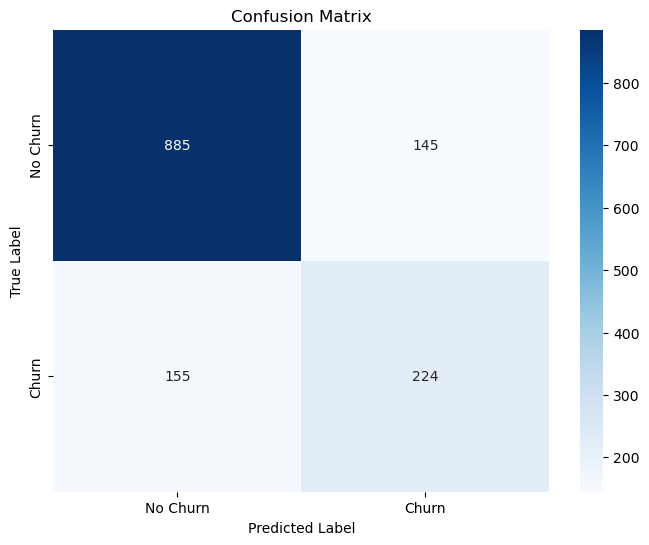

In [21]:
# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [22]:
# Display classification report
class_report = classification_report(y_test, y_pred, target_names=["No Churn", "Churn"])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

    No Churn       0.85      0.86      0.86      1030
       Churn       0.61      0.59      0.60       379

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



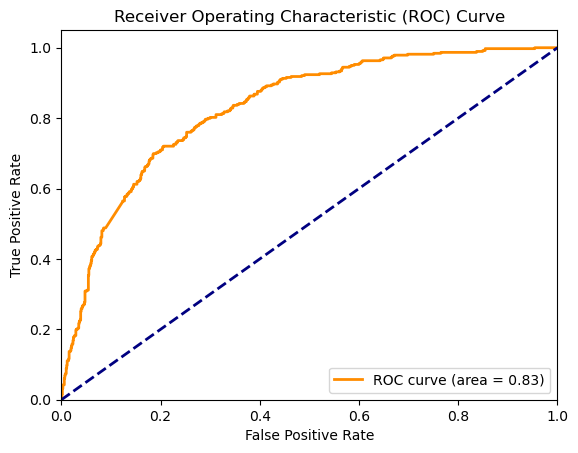

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()